# import data

In [4]:
import pandas as pd
rating_data = pd.read_csv('./movie_lens/rating.csv')
print(rating_data.shape)
rating_data.head()

(20000263, 4)


,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [5]:
raw_movie_data = pd.read_csv('./movie_lens/movie.csv')
print(raw_movie_data.shape)
raw_movie_data.head()

(27278, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
rating_data = rating_data.drop('timestamp',axis=1)

# ID별 갯수 분포 확인

In [10]:
userid_count_df = rating_data['userId'].groupby(rating_data['userId']).count()
print(userid_count_df.shape)
userid_count_df.head()

(138493,)


userId
1    175
2     61
3    187
4     28
5     66
Name: userId, dtype: int64

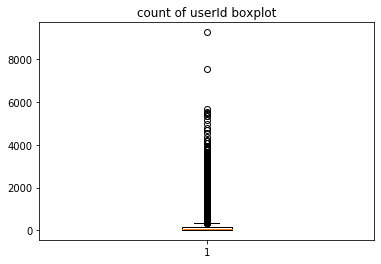

In [15]:
import matplotlib.pyplot as plt
plt.boxplot(userid_count_df)
plt.title("count of userId boxplot")
plt.show()

In [14]:
userid_count_df.describe()

count    138493.000000
mean        144.413530
std         230.267257
min          20.000000
25%          35.000000
50%          68.000000
75%         155.000000
max        9254.000000
Name: userId, dtype: float64

userId의 boxplot을 그려보았을 때 대부분 이상치로 존재하는 것을 볼 수있다.

수치상으로 보았을 때는 최솟값은 20개 이지만, 최댓값은 9254개 이므로 너무 큰 차이가 나는 것을 알 수 있다.

이것으로 보아 리뷰를 남긴 갯수에 따라 적절하게 filtering이 필요하다고 생각이 든다.

# 영화별 리뷰갯수 분포

In [16]:
movieId_count_df = rating_data['movieId'].groupby(rating_data['movieId']).count()
print(movieId_count_df.shape)
movieId_count_df.head()

(26744,)


movieId
1    49695
2    22243
3    12735
4     2756
5    12161
Name: movieId, dtype: int64

In [22]:
movieId_count_df.describe()

count    26744.000000
mean       747.841123
std       3085.818268
min          1.000000
25%          3.000000
50%         18.000000
75%        205.000000
max      67310.000000
Name: movieId, dtype: float64

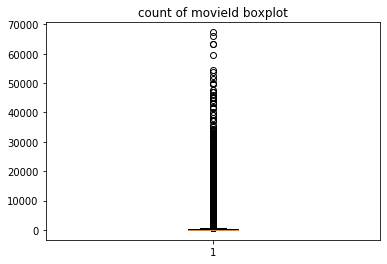

In [23]:
import matplotlib.pyplot as plt
plt.boxplot(movieId_count_df)
plt.title("count of movieId boxplot")
plt.show()

movieId의 boxplot을 그려보았을 때 대부분 이상치로 존재하는 것을 볼 수있다.

수치상으로 보았을 때는 최솟값은 1개 이지만, 최댓값은 67310개 이므로 너무 큰 차이가 나는 것을 알 수 있다.

이것으로 보아 리뷰를 남긴 갯수에 따라 적절하게 filtering이 필요하다고 생각이 든다.

추가적으로 추천시스템에 앞서 영화들의 관계도 살펴보아야 함.

# 영화별 평균 평점 분포

In [25]:
rating_data.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [27]:
movie_rating_df = rating['rating'].groupby(rating_data['movieId']).mean().sort_values(ascending=False)
movie_rating_df.head()

movieId
117606    5.0
88488     5.0
130996    5.0
54326     5.0
121039    5.0
Name: rating, dtype: float64

In [29]:
movie_rating_df.describe()

count    26744.000000
mean         3.133200
std          0.664084
min          0.500000
25%          2.800000
50%          3.235294
75%          3.565217
max          5.000000
Name: rating, dtype: float64

영화별 평균 평점은 평균적으로 3.13점을 이루고 있고 최소점은 0.5점 최댓점은 5점의 분포를 가지고 있다.

그렇다면, 4점 이상의 평가를 하였을 때 그 영화를 '좋다'라고 가정한다면

A영화를 좋아할 때, B영화를 좋아하는 퍼센트는 얼마나 될까?

In [101]:
temp_rating = rating_data.loc[rating_data['rating']==5.0]
temp_rating.shape

(2898660, 3)

In [103]:
temp_rating.head()

,userId,movieId,rating
131,1,4993,5.0
142,1,5952,5.0
158,1,7153,5.0
170,1,8507,5.0
176,2,62,5.0


In [104]:
from tqdm.notebook import tqdm
partial_prob=list()
top_rate = list(temp_rating.movieId.unique())
for i in tqdm(top_rate):
    temp = temp_rating[temp_rating['movieId']==i]['userId'].values
    n = len(temp)
    temp2=temp_rating[temp_rating['userId'].isin(temp)]
    temp2 = temp2[~temp2['movieId'].isin([i])]
    b = temp2['movieId'].groupby(temp2['movieId']).count().max()
    partial_prob.append(b/n)

In [120]:
np.nansum(np.array(partial_prob))/len(partial_prob)

0.7054471095540753

평균적으로 A라는 특정한 영화를 좋아하는 사람들이 같은 영화를 좋아하는 비율은 70%이라는 것을 알 수 있다.

이는 사람들이 한 영화에 대해 '좋다'라고 표현하면, 비슷한 영화를 추천할 시에 같이 '좋다'라고 나올 수 있다는 것이다.

# 연도별 영화 분포

In [121]:
raw_movie_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [147]:
def movie_filter(input_data, year=0, genres=None):
    data = input_data.copy() 
    
    data['year'] = data['title'].str[-5:-1]
    data['year'] = pd.to_numeric(data['year'], downcast='integer', errors='coerce')
    data = data.dropna(axis=0)    
    
    data['genres'] = data['genres'].str.split('|')
    
    data = data[data['year']>=year]
    
    if genres==None:
        return data.reset_index(drop=True)
    
    
    mask = []
    for genre_ in data['genres']:
        mask.append(True if np.intersect1d(genre_, genres).size > 0 else False) 
            
    data = data[mask].reset_index(drop=True)
    
    return data

In [148]:
movie_data = movie_filter(raw_movie_data)

In [127]:
movie_data.head()

,movieId,title,genres,year
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995.0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1995.0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995.0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995.0
4,5,Father of the Bride Part II (1995),[Comedy],1995.0


In [129]:
def year_filter(data):
    if data>=2010.0:
        years = '2010년대'
    elif data>=2000.0:
        years = '2000년대'
    elif data >=1990.0:
        years = '1990년대'
    elif data >= 1980.0:
        years = '1980년대'
    elif data >= 1970.0:
        years = '1970년대'
    else:
        years = '나머지'
    return years

In [131]:
movie_data['years'] = movie_data['year'].apply(year_filter)

In [132]:
movie_data.head()

,movieId,title,genres,year,years
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995.0,1990년대
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1995.0,1990년대
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995.0,1990년대
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995.0,1990년대
4,5,Father of the Bride Part II (1995),[Comedy],1995.0,1990년대


In [134]:
count_year_movie_df = movie_data['years'].groupby(movie_data['years']).count()

In [135]:
count_year_movie_df

years
1970년대    2017
1980년대    2652
1990년대    4370
2000년대    7866
2010년대    4863
나머지       5459
Name: years, dtype: int64

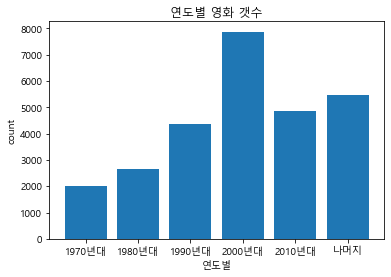

In [140]:
plt.bar(count_year_movie_df.index,count_year_movie_df)
plt.title('연도별 영화 갯수')
plt.xlabel('연도별')
plt.ylabel('count')
plt.rc('font',family='malgun gothic')
plt.show()

# 영화 장르별 분포

In [156]:
a = list()
for i in tqdm(range(len(movie_data))):
    temp = movie_data['genres'][i]
    for j in temp:
        a.append(j)
count_genre = {x:a.count(x) for x in a}

In [168]:
genre_movie_df = pd.DataFrame.from_dict([count_genre]).T.sort_values(by=0,ascending=False)

In [169]:
genre_movie_df.head()

,0
Drama,13322
Comedy,8367
Thriller,4170
Romance,4126
Action,3514


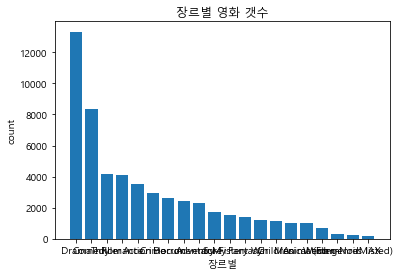

In [170]:
plt.bar(genre_movie_df.index,genre_movie_df[0])
plt.title('장르별 영화 갯수')
plt.xlabel('장르별')
plt.ylabel('count')
plt.rc('font',family='malgun gothic')
plt.show()